# Projekt: Klasyfikacja Znaków Drogowych (GTSRB)
**Autorzy:** Kamil Klepusewicz 280118 Szymon Brodziak 280133 

## 1. Definicja problemu
Celem projektu jest stworzenie modelu sieci neuronowej, który na podstawie zdjęcia przypisze je do jednej z **43 klas** znaków drogowych. Jest to problem **klasyfikacji wieloklasowej (Multi-class classification)** obrazów.

## 2. Wybór architektury sieci
Do rozwiązania problemu wybrano **Konwolucyjną Sieć Neuronową (CNN)**.
**Uzasadnienie:** Sieci CNN są standardem w przetwarzaniu obrazu (Computer Vision). Dzięki warstwom konwolucyjnym potrafią wykrywać lokalne cechy (krawędzie, kształty, kolory) niezależnie od ich położenia na zdjęciu, co jest kluczowe przy rozpoznawaniu znaków drogowych w różnych warunkach oświetleniowych i pod różnymi kątami.

In [1]:
!pip install protobuf==3.20.3
!pip install -U "tensorflow>=2.10.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 6.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tensorflow-me

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Uciszenie czerwonych logów TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

DATA_DIR = '/kaggle/input/gtsrb-german-traffic-sign'
TRAIN_PATH = os.path.join(DATA_DIR, 'Train')
IMG_HEIGHT = 30
IMG_WIDTH = 30
NUM_CLASSES = 43

print("Biblioteki gotowe.")

Biblioteki gotowe.


In [3]:
MIN_SAMPLES = 350  # Zostawiamy tylko klasy, które mają minimum 350 zdjęć
# -------------------------------

image_data = []
image_labels = []
new_class_mapping = {}
current_new_id = 0

print(f"Filtrowanie klas (Minimum {MIN_SAMPLES} zdjęć)...")

# SPRAWDZAMY KTÓRE KLASY ZOSTAJĄ
valid_classes = []
for i in range(NUM_CLASSES): # NUM_CLASSES to oryginalne 43
    path = os.path.join(TRAIN_PATH, str(i))
    count = len(os.listdir(path))
    
    if count >= MIN_SAMPLES:
        valid_classes.append(i)
        new_class_mapping[i] = current_new_id # Stare ID -> Nowe ID (np. 42 -> 25)
        current_new_id += 1

REAL_NUM_CLASSES = len(valid_classes)
print(f"Zredukowano liczbę klas z {NUM_CLASSES} do {REAL_NUM_CLASSES}.")

print("Rozpoczynam wczytywanie zdjęć...")

for old_id in valid_classes:
    path = os.path.join(TRAIN_PATH, str(old_id))
    images = os.listdir(path)
    
    # Postęp co kilka folderów
    if old_id % 5 == 0:
        print(f"Wczytywanie oryginalnej klasy: {old_id}...")

    for img in images:
        if img.lower().endswith(('.png', '.jpg', '.jpeg', '.ppm')):
            try:
                image = Image.open(path + '/' + img)
                image = image.resize((IMG_HEIGHT, IMG_WIDTH))
                image = np.array(image)
                
                image_data.append(image)
                # Przypisujemy NOWE ID (bez dziur w numeracji)
                image_labels.append(new_class_mapping[old_id])
            except:
                pass

X = np.array(image_data)
y = np.array(image_labels)

# Tasowanie
shuffle_indexes = np.arange(X.shape[0])
np.random.shuffle(shuffle_indexes)
X = X[shuffle_indexes]
y = y[shuffle_indexes]

# Podział
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizacja
X_train = X_train / 255.0
X_val = X_val / 255.0

y_train = to_categorical(y_train, REAL_NUM_CLASSES)
y_val = to_categorical(y_val, REAL_NUM_CLASSES)

print("--- SUKCES ---")
print(f"Dane gotowe. Liczba klas po filtracji: {REAL_NUM_CLASSES}")
print(f"Wymiary X_train: {X_train.shape}")

Filtrowanie klas (Minimum 350 zdjęć)...
Zredukowano liczbę klas z 43 do 32.
Rozpoczynam wczytywanie zdjęć...
Wczytywanie oryginalnej klasy: 5...
Wczytywanie oryginalnej klasy: 10...
Wczytywanie oryginalnej klasy: 15...
Wczytywanie oryginalnej klasy: 20...
Wczytywanie oryginalnej klasy: 25...
Wczytywanie oryginalnej klasy: 30...
Wczytywanie oryginalnej klasy: 35...
Wczytywanie oryginalnej klasy: 40...
--- SUKCES ---
Dane gotowe. Liczba klas po filtracji: 32
Wymiary X_train: (29159, 30, 30, 3)


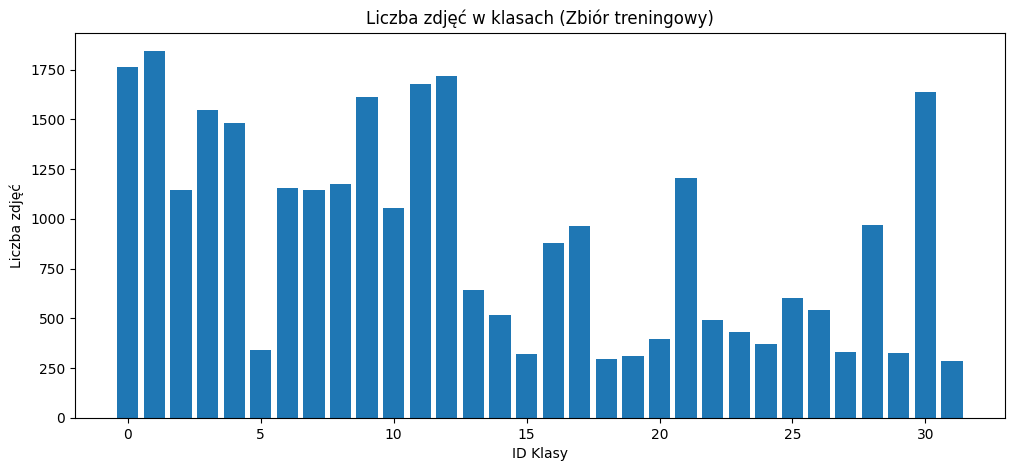

Przykładowe zdjęcia z przetworzonego zbioru:


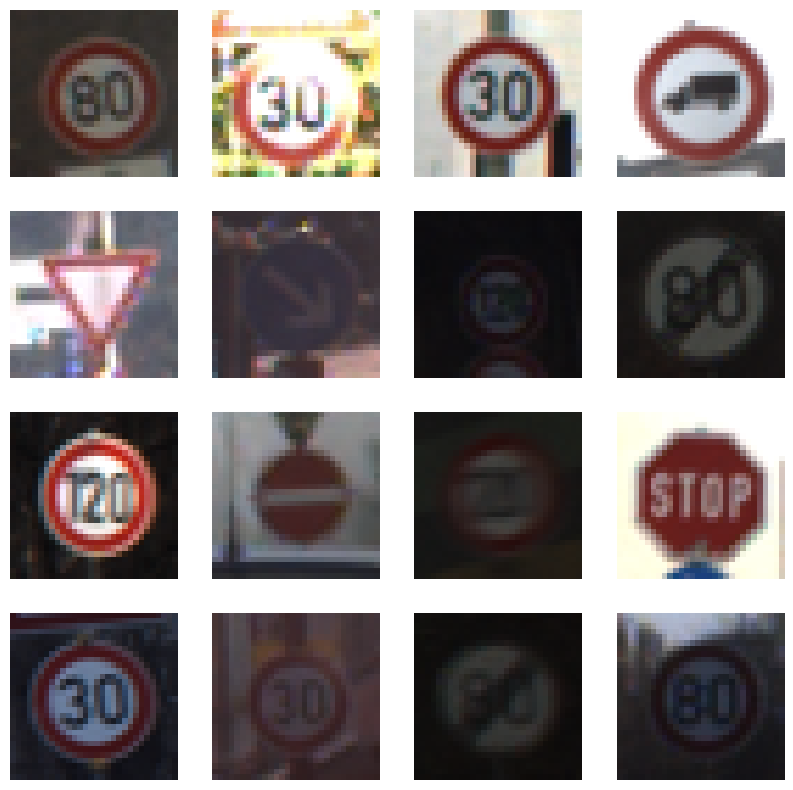

In [4]:
# Analiza - Wykres słupkowy
plt.figure(figsize=(12, 5))
# Szybkie zliczanie klas w już wczytanym zbiorze
unique, counts = np.unique(np.argmax(y_train, axis=1), return_counts=True)
plt.bar(unique, counts)
plt.title("Liczba zdjęć w klasach (Zbiór treningowy)")
plt.xlabel("ID Klasy")
plt.ylabel("Liczba zdjęć")
plt.show()

# Podgląd zdjęć
print("Przykładowe zdjęcia z przetworzonego zbioru:")
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    # Wyświetlamy zdjęcie z X_train (pamiętając, że jest znormalizowane 0-1)
    plt.imshow(X_train[i])
    plt.axis('off')
plt.show()

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def build_model():
    model = Sequential()

    model.add(Input(shape=(30, 30, 3)))

    model.add(Conv2D(32, (5,5), activation='relu')) 
    model.add(Conv2D(32, (5,5), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    # Warstwa wyjściowa (dostosowana do liczby klas po filtracji)
    model.add(Dense(REAL_NUM_CLASSES, activation='softmax'))
    
    return model

model = build_model()
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, batch_size=64, epochs=20, validation_data=(X_val, y_val), callbacks=[early_stop])

I0000 00:00:1768899351.560339      47 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/20
 40/456 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0451 - loss: 3.4134

I0000 00:00:1768899359.198642     128 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


456/456 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.5555 - loss: 1.5365 - val_accuracy: 0.9543 - val_loss: 0.1860
Epoch 2/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9180 - loss: 0.2676 - val_accuracy: 0.9830 - val_loss: 0.0705
Epoch 3/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9539 - loss: 0.1511 - val_accuracy: 0.9898 - val_loss: 0.0436
Epoch 4/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9675 - loss: 0.1097 - val_accuracy: 0.9933 - val_loss: 0.0299
Epoch 5/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9726 - loss: 0.0908 - val_accuracy: 0.9938 - val_loss: 0.0289
Epoch 6/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9773 - loss: 0.0743 - val_accuracy: 0.9923 - val_loss: 0.0301
Epoch 7/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9791 - loss: 0.0685 - val_accuracy: 0.9952 - val_loss: 0.0208
Epoch 8/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9812 - loss: 0.0611 - val_accuracy: 0.9959 - va

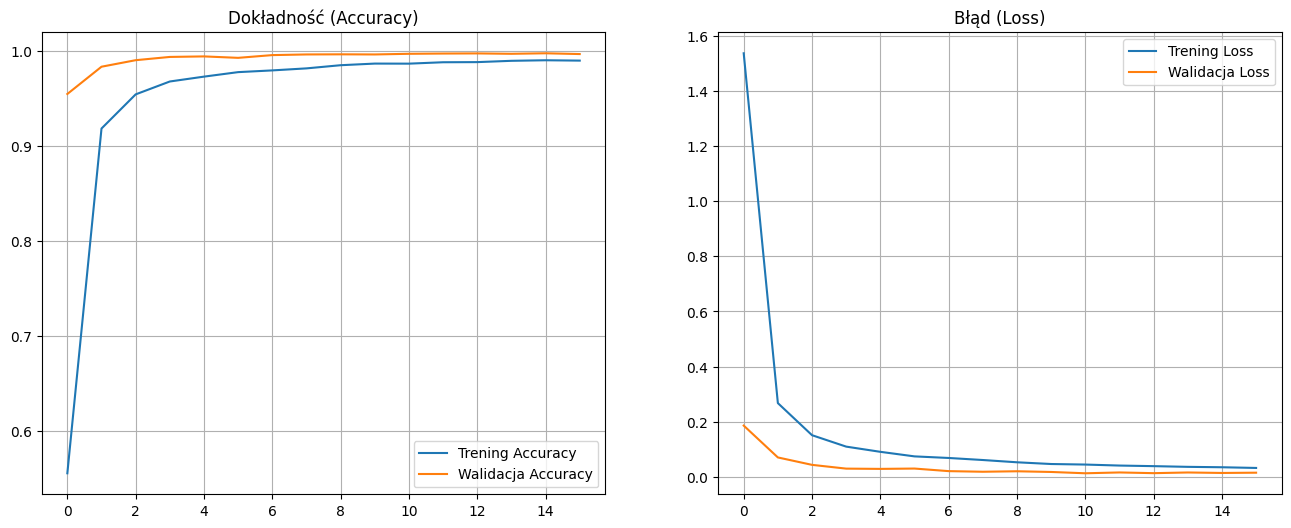

In [6]:
import matplotlib.pyplot as plt

# Pobieramy dane z historii treningu
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(16, 6))

# Wykres 1: Dokładność (Accuracy)
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Trening Accuracy')
plt.plot(epochs_range, val_acc, label='Walidacja Accuracy')
plt.legend(loc='lower right')
plt.title('Dokładność (Accuracy)')
plt.grid(True)

# Wykres 2: Błąd (Loss)
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Trening Loss')
plt.plot(epochs_range, val_loss, label='Walidacja Loss')
plt.legend(loc='upper right')
plt.title('Błąd (Loss)')
plt.grid(True)

plt.show()

228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


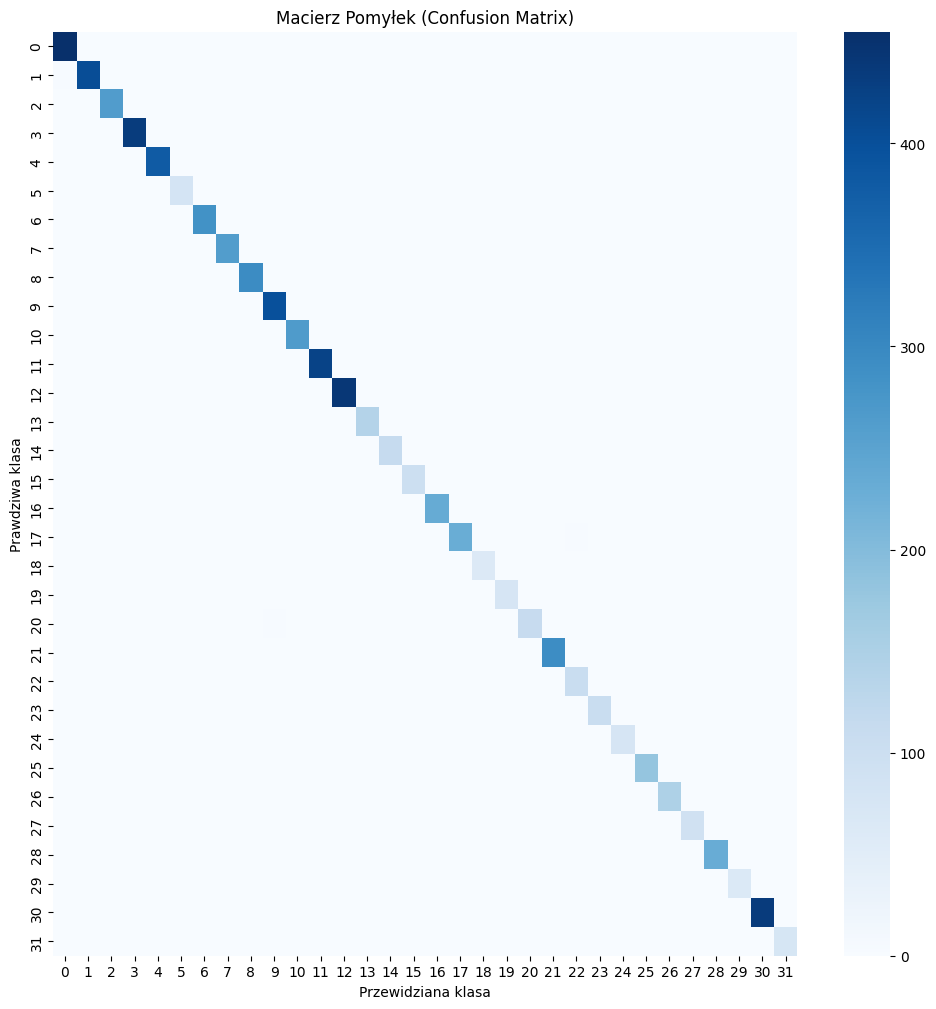

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 1. Robimy predykcje dla całego zbioru walidacyjnego
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

# 2. Tworzymy Macierz Pomyłek
cm = confusion_matrix(y_true, y_pred_classes)

# 3. Rysujemy ładną mapę ciepła
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=False, cmap='Blues', fmt='g') # annot=True jeśli chcesz liczby w kratkach (może być nieczytelne przy dużej macierzy)
plt.title('Macierz Pomyłek (Confusion Matrix)')
plt.xlabel('Przewidziana klasa')
plt.ylabel('Prawdziwa klasa')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


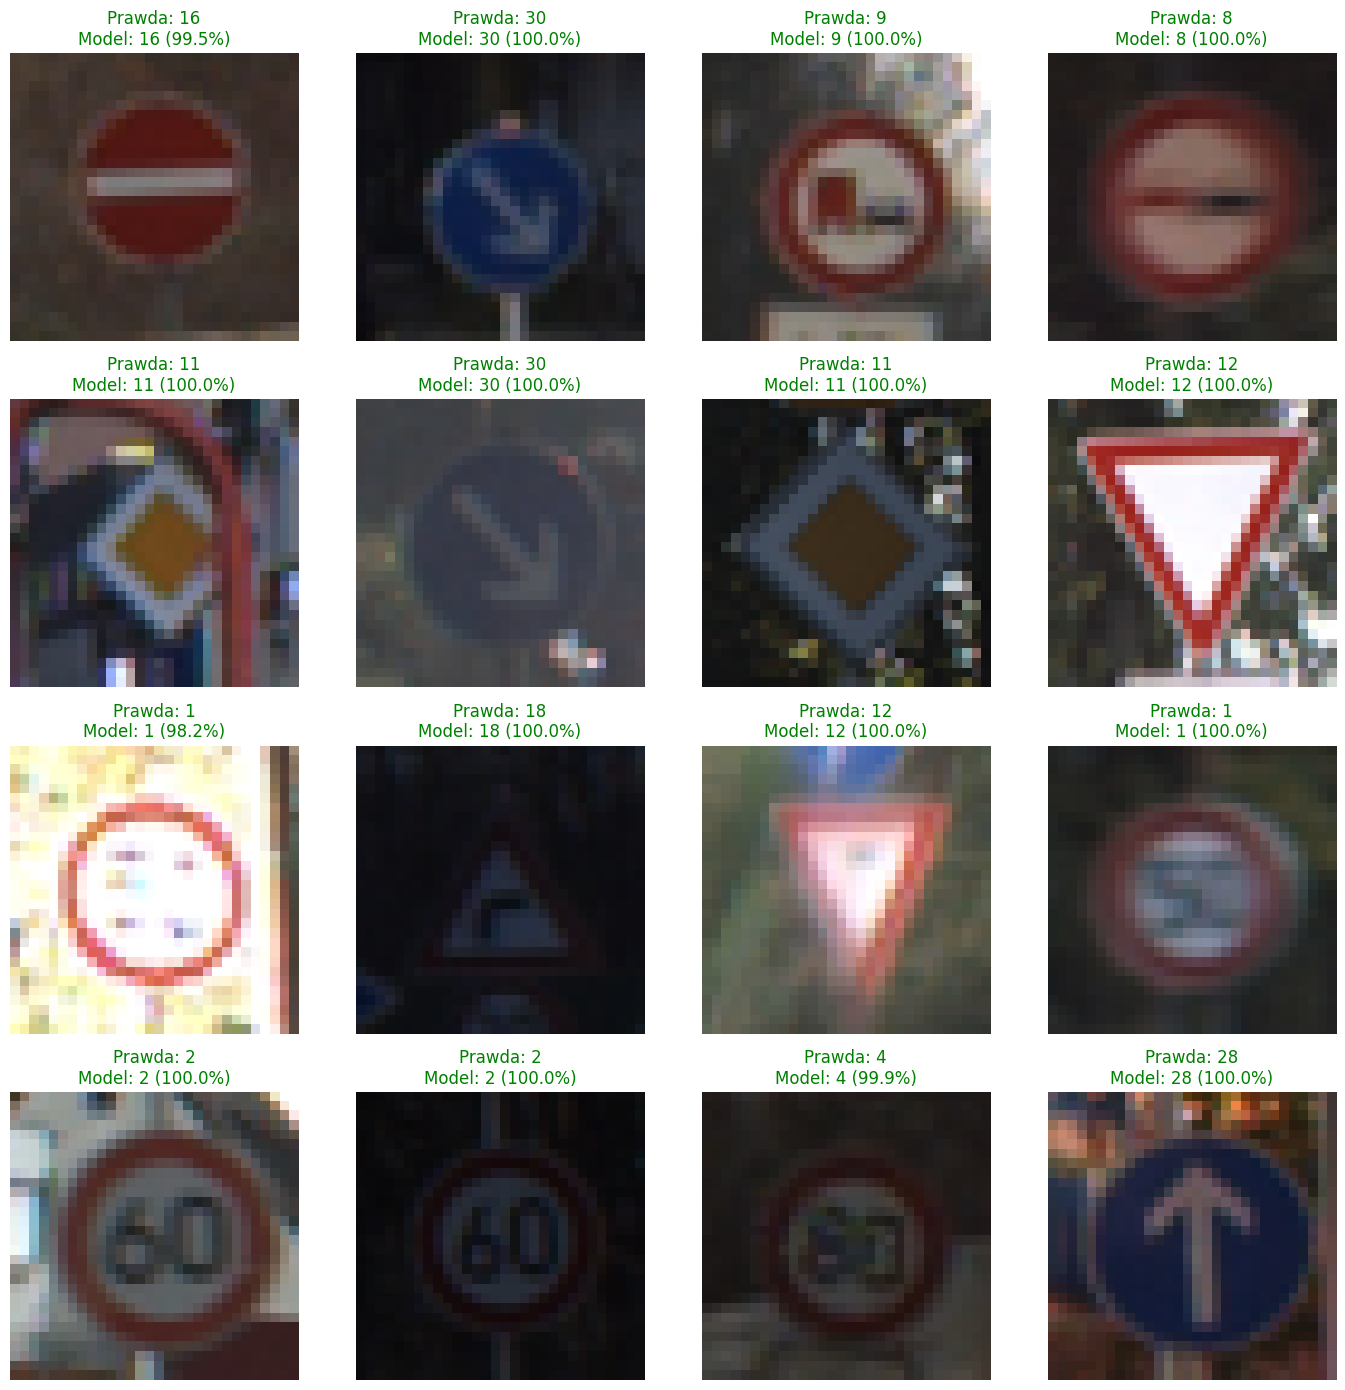

In [8]:
plt.figure(figsize=(14, 14))

# Losujemy 16 indeksów
random_indexes = np.random.choice(len(X_val), 16, replace=False)

for i, idx in enumerate(random_indexes):
    image = X_val[idx]
    true_label = np.argmax(y_val[idx])
    
    # Predykcja dla tego jednego zdjęcia
    pred_probs = model.predict(np.expand_dims(image, axis=0))
    pred_label = np.argmax(pred_probs)
    confidence = np.max(pred_probs) * 100
    
    # Kolor napisu: Zielony jak dobrze, Czerwony jak źle
    color = 'green' if true_label == pred_label else 'red'
    
    plt.subplot(4, 4, i+1)
    plt.imshow(image)
    plt.title(f"Prawda: {true_label}\nModel: {pred_label} ({confidence:.1f}%)", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()

Rozpoczynam trening modelu porównawczego (SGD)...
Epoch 1/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.0591 - loss: 3.3929 - val_accuracy: 0.1130 - val_loss: 3.2925
Epoch 2/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1049 - loss: 3.2476 - val_accuracy: 0.1911 - val_loss: 3.0769
Epoch 3/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2565 - loss: 2.7638 - val_accuracy: 0.5329 - val_loss: 1.8814
Epoch 4/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5076 - loss: 1.7509 - val_accuracy: 0.7877 - val_loss: 0.8998
Epoch 5/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6813 - loss: 1.0720 - val_accuracy: 0.8715 - val_loss: 0.5093
Epoch 6/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7761 - loss: 0.7559 - val_accuracy: 0.9237 - val_loss: 0.3375
Epoch 7/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8300 - loss: 0.5759 - val_accuracy: 0.9385 - val_loss: 0.2552
Epoch 8/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step -

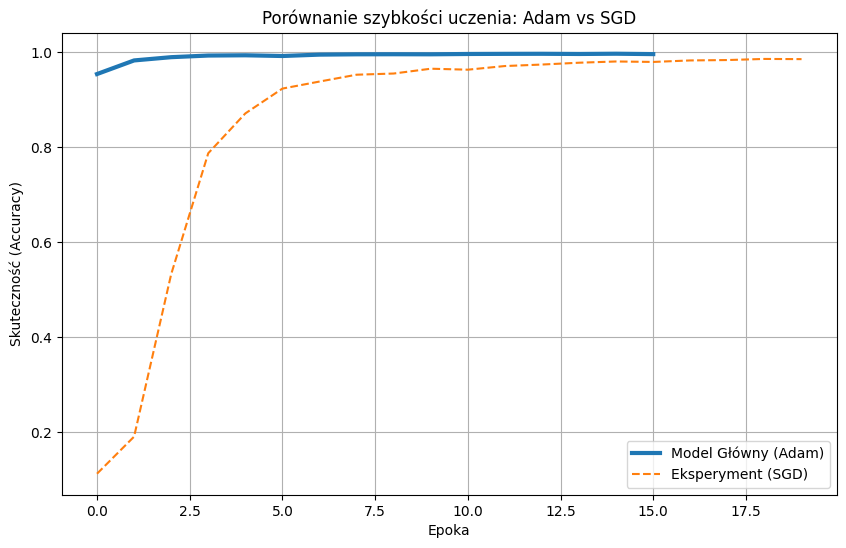

In [9]:
#EKSPERYMENT PORÓWNAWCZY (MODEL SGD)

# 1. Budujemy taki sam model
model_sgd = build_model()

# 2. Zmieniamy optymalizator na SGD
from tensorflow.keras.optimizers import SGD
model_sgd.compile(loss='categorical_crossentropy', 
                  optimizer=SGD(learning_rate=0.01),
                  metrics=['accuracy'])

print("Rozpoczynam trening modelu porównawczego (SGD)...")
history_sgd = model_sgd.fit(X_train, y_train, 
                            batch_size=64, 
                            epochs=20,
                            validation_data=(X_val, y_val),
                            verbose=1) # verbose=1 żeby widzieć pasek

# 3. Wykres porównawczy (Adam vs SGD)
plt.figure(figsize=(10, 6))
plt.plot(history.history['val_accuracy'], label='Model Główny (Adam)', linewidth=3)
plt.plot(history_sgd.history['val_accuracy'], label='Eksperyment (SGD)', linestyle='--')
plt.title('Porównanie szybkości uczenia: Adam vs SGD')
plt.xlabel('Epoka')
plt.ylabel('Skuteczność (Accuracy)')
plt.legend()
plt.grid(True)
plt.show()